# Longitudinal QuasiCopula GWAS

Here we adopt the variance component model framework

$$\mathbf{\Gamma}_i(\mathbf{\theta}) = \sum_{k=1}^m \theta_k\mathbf{V}_{ik}, \quad \theta_k \ge 0$$

In [1]:
using Revise
using DataFrames, Random, GLM, QuasiCopula
using ForwardDiff, Test, LinearAlgebra
using LinearAlgebra: BlasReal, copytri!
using ToeplitzMatrices
using BenchmarkTools
using SnpArrays
using MendelPlots

# using MendelPlots
ENV["COLUMNS"] = 240

BLAS.set_num_threads(1)
Threads.nthreads()

# simulate PLINK data where each SNP has at least min_ma copies of the alt allele
function simulate_random_snparray(s::Union{String, UndefInitializer}, n::Int64,
        p::Int64, mafs::Vector{Float64}; min_ma::Int = 1)
    all(0.0 .<= mafs .<= 0.5) || throw(ArgumentError("vector of minor allele frequencies must be in (0, 0.5)"))
#     any(mafs .<= 0.0005) && @warn("Provided minor allele frequencies contain entries smaller than 0.0005, simulation may take long if sample size is small and min_ma = $min_ma is large")

    #first simulate a random {0, 1, 2} matrix with each SNP drawn from Binomial(2, r[i])
    A1 = BitArray(undef, n, p) 
    A2 = BitArray(undef, n, p) 
    for j in 1:p
        minor_alleles = 0
        maf = mafs[j]
        while minor_alleles <= min_ma
            for i in 1:n
                A1[i, j] = rand(Bernoulli(maf))
                A2[i, j] = rand(Bernoulli(maf))
            end
            minor_alleles = sum(view(A1, :, j)) + sum(view(A2, :, j))
        end
    end

    #fill the SnpArray with the corresponding x_tmp entry
    return _make_snparray(s, A1, A2)
end


# function simulate_random_snparray(s::Union{String, UndefInitializer}, n::Int64,
#     p::Int64; mafs::Vector{Float64}=zeros(Float64, p), min_ma::Int = 5)

#     #first simulate a random {0, 1, 2} matrix with each SNP drawn from Binomial(2, r[i])
#     A1 = BitArray(undef, n, p) 
#     A2 = BitArray(undef, n, p) 
#     for j in 1:p
#         minor_alleles = 0
#         maf = 0
#         while minor_alleles <= min_ma
#             maf = 0.5rand()
#             for i in 1:n
#                 A1[i, j] = rand(Bernoulli(maf))
#                 A2[i, j] = rand(Bernoulli(maf))
#             end
#             minor_alleles = sum(view(A1, :, j)) + sum(view(A2, :, j))
#         end
#         mafs[j] = maf
#     end

#     #fill the SnpArray with the corresponding x_tmp entry
#     return _make_snparray(s, A1, A2)
# end

function _make_snparray(s::Union{String, UndefInitializer}, A1::BitArray, A2::BitArray)
    n, p = size(A1)
    x = SnpArray(s, n, p)
    for i in 1:(n*p)
        c = A1[i] + A2[i]
        if c == 0
            x[i] = 0x00
        elseif c == 1
            x[i] = 0x02
        elseif c == 2
            x[i] = 0x03
        else
            throw(MissingException("matrix shouldn't have missing values!"))
        end
    end
    return x
end

┌ Info: Precompiling QuasiCopula [c47b6ae2-b804-4668-9957-eb588c99ffbc]
└ @ Base loading.jl:1342


_make_snparray (generic function with 1 method)

## Simulate data

In [2]:
function simulate_VC_longitudinal(;
    n = 1000, # sample size
    d_min = 1, # min number of observations per sample
    d_max = 5, # max number of observations per sample
    p = 3, # number of nongenetic covariates, including intercept
    m = 1, # number of variance components
    q = 1000, # number of SNPs
    k = 10, # number of causal SNPs
    maf = 0.5rand(),
    causal_snp_β = 0.5rand(),
    seed = 2022,
    y_distribution = Bernoulli,
    T = Float64,
    )
    Random.seed!(seed)
    m == 1 || m == 2 || error("m (number of VC) must be 1 or 2")
    
    # non-genetic effect sizes
    Random.seed!(seed)
#     βtrue = [1.0; rand(-0.05:0.1:0.05, p-1)]
    βtrue = [1.0; rand(-0.5:1:0.5, p-1)]
#     βtrue = [1.0; rand(-5:10:5, p-1) .* rand(Uniform(0, 5), p-1)]
    dist = y_distribution()
    link = y_distribution == NegativeBinomial ? LogLink() : canonicallink(dist)
    Dist = typeof(dist)
    Link = typeof(link)

    # variance components
    θtrue = fill(0.1, m)

    # simulate (nongenetic) design matrices
    Random.seed!(seed)
    X_full = Matrix{Float64}[]
    for i in 1:n
        nobs = rand(d_min:d_max) # number of obs for this sample
        push!(X_full, hcat(ones(nobs), randn(nobs, p - 1)))
    end
    
    # simulate causal alleles
    Random.seed!(seed)
    γtrue = zeros(q)
    γtrue[1:k] .= causal_snp_β
    shuffle!(γtrue)
    
    # set minor allele freq
    mafs = fill(maf, q)
    
    # simulate random SnpArray with q SNPs with prespecified maf
    Random.seed!(seed)
    G = simulate_random_snparray(undef, n, q, mafs)
    Gfloat = convert(Matrix{T}, G, center=true, scale=false)
    
    # effect of causal alleles
    η_G = Gfloat * γtrue

    # simulate phenotypes
    if y_distribution == Normal
        τtrue = 100.0
        σ2 = inv(τtrue)
        σ = sqrt(σ2)
        obs = Vector{GaussianCopulaVCObs{T}}(undef, n)
        for i in 1:n
            # data matrix
            X = X_full[i]
            η = X * βtrue
            η .+= η_G[i] # add genetic effects
            μ = GLM.linkinv.(link, η)
            vecd = Vector{ContinuousUnivariateDistribution}(undef, size(X, 1))
            # VC matrices
            V1 = ones(size(X, 1), size(X, 1))
            V2 = Matrix(I, size(X, 1), size(X, 1))
            Γ = m == 1 ? θtrue[1] * V1 : θtrue[1] * V1 + θtrue[2] * V2
            for i in 1:size(X, 1)
                vecd[i] = y_distribution(μ[i], σ)
            end
            nonmixed_multivariate_dist = NonMixedMultivariateDistribution(vecd, Γ)
            # simuate single vector y
            y = Vector{T}(undef, size(X, 1))
            res = Vector{T}(undef, size(X, 1))
            rand(nonmixed_multivariate_dist, y, res)
            V = m == 1 ? [V1] : [V1, V2]
            obs[i] = GaussianCopulaVCObs(y, X, V)
        end
        qc_model = GaussianCopulaVCModel(obs)
    elseif y_distribution == NegativeBinomial
        rtrue = 10.0
        obs = Vector{NBCopulaVCObs{T, Dist, Link}}(undef, n)
        for i in 1:n
            # data matrix
            X = X_full[i]
            η = X * βtrue
            η .+= η_G[i] # add genetic effects
            μ = GLM.linkinv.(link, η)
            p = rtrue ./ (μ .+ rtrue)
            vecd = [NegativeBinomial(rtrue, p[i]) for i in 1:size(X, 1)]
            # VC matrices
            V1 = ones(size(X, 1), size(X, 1))
            V2 = Matrix(I, size(X, 1), size(X, 1))
            Γ = m == 1 ? θtrue[1] * V1 : θtrue[1] * V1 + θtrue[2] * V2
            nonmixed_multivariate_dist = NonMixedMultivariateDistribution(vecd, Γ)
            # simuate single vector y
            y = Vector{Float64}(undef, size(X, 1))
            res = Vector{Float64}(undef, size(X, 1))
            rand(nonmixed_multivariate_dist, y, res)
            V = m == 1 ? [V1] : [V1, V2]
            obs[i] = NBCopulaVCObs(y, X, V, dist, link)
        end
        qc_model = NBCopulaVCModel(obs)
    else # Bernoulli or Poisson
        obs = Vector{GLMCopulaVCObs{T, Dist, Link}}(undef, n)
        for i in 1:n
            # data matrix
            X = X_full[i]
            η = X * βtrue
            η .+= η_G[i] # add genetic effects
            μ = GLM.linkinv.(link, η)
            # VC matrices
            V1 = ones(size(X, 1), size(X, 1))
            V2 = Matrix(I, size(X, 1), size(X, 1))
            Γ = m == 1 ? θtrue[1] * V1 : θtrue[1] * V1 + θtrue[2] * V2
            vecd = Vector{DiscreteUnivariateDistribution}(undef, size(X, 1))
            for i in 1:size(X, 1)
                vecd[i] = y_distribution(μ[i])
            end
            nonmixed_multivariate_dist = NonMixedMultivariateDistribution(vecd, Γ)
            # simuate single vector y
            y = Vector{T}(undef, size(X, 1))
            res = Vector{T}(undef, size(X, 1))
            rand(nonmixed_multivariate_dist, y, res)
            V = m == 1 ? [V1] : [V1, V2]
            obs[i] = GLMCopulaVCObs(y, X, V, dist, link)
        end
        qc_model = GLMCopulaVCModel(obs)
    end
    return qc_model, G, βtrue, θtrue, γtrue
end

k = 0 # number of causal SNPs
maf = 0.3

qc_model, G, βtrue, θtrue, γtrue = simulate_VC_longitudinal(
    n = 5000, # sample size
    d_min = 1, # min number of observations per sample
    d_max = 5, # max number of observations per sample
    p = 3, # number of fixed effects, including intercept
    m = 2, # number of variance components
    q = 1000, # number of SNPs
    k = k, # number of causal SNPs
    seed = 2022,
    y_distribution = NegativeBinomial,
    T = Float64,
    maf = maf,
    causal_snp_β = 0.2
)

@show qc_model;

qc_model = Quasi-Copula Variance Component Model
  * base distribution: NegativeBinomial
  * link function: LogLink
  * number of clusters: 5000
  * cluster size min, max: 1, 5
  * number of variance components: 2
  * number of fixed effects: 3



## Fit Null model

In [17]:
@time optm = QuasiCopula.fit!(qc_model,
    Ipopt.IpoptSolver(
        print_level = 5, 
        tol = 10^-6, 
        max_iter = 1000,
        accept_after_max_steps = 50,
        warm_start_init_point="yes", 
        limited_memory_max_history = 6, # default value
        hessian_approximation = "limited-memory",
#         derivative_test="first-order"
    )
);

initializing β using GLM.jl
gcm.β = [1.0497967268085835, 0.47957248664624846, 0.4881022940269102]
initializing variance components using MM-Algorithm
gcm.θ = [0.09172848338958824, 0.01936564613542114]
initializing r using Newton update
Converging when tol ≤ 1.0e-6 (max block iter = 10)
This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        5
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:   

In [18]:
@show βtrue
@show qc_model.β
@show qc_model.∇β

@show θtrue
@show qc_model.θ
@show qc_model.∇θ;

@show qc_model.τ
@show qc_model.∇τ;

βtrue = [1.0, 0.5, 0.5]
qc_model.β = [1.0110780938476065, 0.49098116855201407, 0.49809263947189575]
qc_model.∇β = [1.2730704028115845, 0.24021887022282118, 0.23598201774681615]
θtrue = [0.1, 0.1]
qc_model.θ = [0.0998871577283528, 0.05355670196910613]
qc_model.∇θ = [4.221941568064722, 4.792173980575171]
qc_model.τ = [1.0]
qc_model.∇τ = [3.095486803e-314]


In [19]:
@show qc_model.r
@show qc_model.∇r;

qc_model.r = [9.453573398478873]
qc_model.∇r = [-26.827916978780003]


## Score tests

In [20]:
# neg bin
@time pvals = QuasiCopula.GWASCopulaVCModel(qc_model, G)

Wtime = 32.659787177340526
Qtime = 4.178188889002064
Rtime = 1.087551119998451
 41.632345 seconds (582.88 M allocations: 53.080 GiB, 9.06% gc time)


1000-element Vector{Float64}:
 0.79480730591239
 0.9565020593418627
 0.3031276225616457
 0.3911148104246353
 0.9107840024526468
 0.6205948917971431
 0.21292468298875103
 0.7584343182629798
 0.2366730347187306
 0.1750342083133523
 0.9100566571691595
 0.6519513401467674
 0.19469699597495915
 ⋮
 0.7422014842147266
 0.8348805136383132
 0.9686182410352158
 0.7056935996964189
 0.6962167842601805
 0.6418420259016995
 0.7511667042671152
 0.06866135406954778
 0.3949773941297067
 0.16621966320786935
 0.9795989888780614
 0.5251057844036325

In [46]:
# bernoulli
@time pvals = QuasiCopula.GWASCopulaVCModel(qc_model, G)

LoadError: InterruptException:

In [61]:
# gaussian
@time pvals = QuasiCopula.GWASCopulaVCModel(qc_model, G)

Wtime = 33.59436863534545
Qtime = 4.213189160079309
Rtime = 0.768581058045112
 41.997066 seconds (543.38 M allocations: 49.853 GiB, 8.92% gc time, 0.26% compilation time)


1000-element Vector{Float64}:
 0.17137128652175276
 0.43415803549385623
 0.35129479595329144
 0.8394000343764324
 0.6801773064491721
 0.5908022142376219
 0.7898500761989526
 0.7044936775252658
 0.6940182858511476
 0.06634364226410244
 0.6678368518056075
 0.6617143474197119
 0.5315740665897692
 ⋮
 0.6005091356508595
 0.5136096517093748
 0.6060152310298466
 0.8103722607180806
 0.20919925549495763
 0.7652262230250056
 0.8706451449620455
 0.20871141280052474
 0.9868665449576759
 0.04663632700635264
 0.913064488116446
 0.6987478483268167

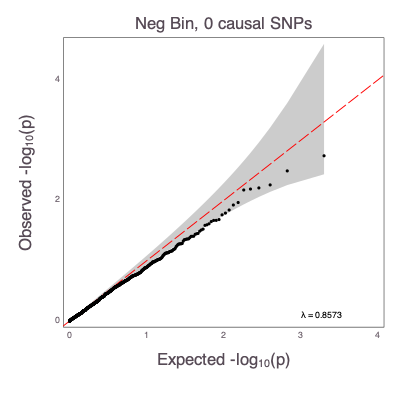

In [9]:
qq(pvals, dpi=80, titles="Neg Bin, $k causal SNPs")
display("image/png", read("qqplot.png"))

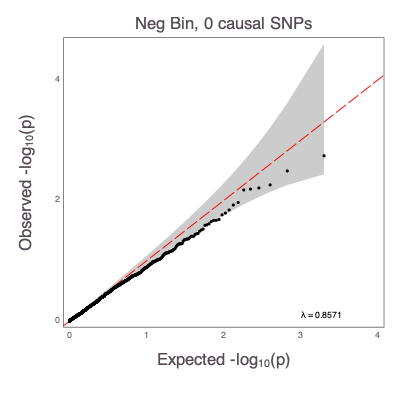

In [21]:
qq(pvals, dpi=80, titles="Neg Bin, $k causal SNPs")
display("image/png", read("qqplot.png"))

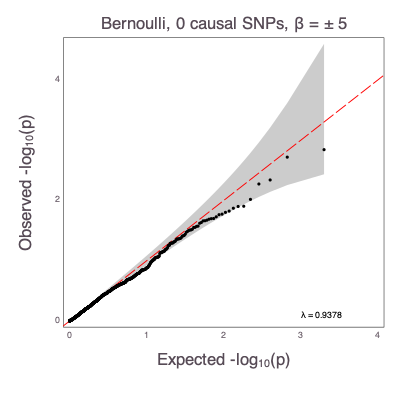

In [44]:
qq(pvals, dpi=80, titles="Bernoulli, $k causal SNPs, β = ± 5")
display("image/png", read("qqplot.png"))

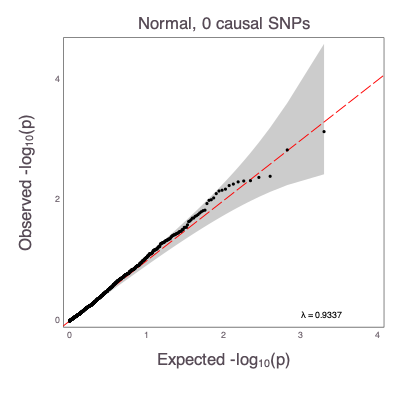

In [63]:
qq(pvals, dpi=80, titles="Normal, $k causal SNPs")
display("image/png", read("qqplot.png"))

In [33]:
# autodiff neg bin
@time pvals = QuasiCopula.GWASCopulaVCModel_autodiff(qc_model, G)

size(Hfull, 1) = 7
rank(Hfull) = 6
rank(Hfull[1:end - 1, 1:end - 1]) = 5


LoadError: SingularException(4)

In [66]:
# autodiff gaussian
@time pvals = QuasiCopula.GWASCopulaVCModel_autodiff(qc_model, G)

 27.280767 seconds (13.59 M allocations: 755.576 MiB, 0.50% gc time, 12.51% compilation time)


1000-element Vector{Float64}:
 0.17120321640591382
 0.43341328809194507
 0.3511494954678522
 0.8392169501079304
 0.680083815495358
 0.5905240715882919
 0.7897820104533161
 0.7044182319736411
 0.6939609281615305
 0.0660561508871385
 0.6678007826563708
 0.6616258540458355
 0.5314803448251156
 ⋮
 0.6004117509675786
 0.512333175931102
 0.605725378269697
 0.8103209063230566
 0.2090841576111163
 0.764954764743121
 0.8705980333029041
 0.20854589224810335
 0.9868616519224109
 0.046429501014578316
 0.9130283650183032
 0.6985398882027449

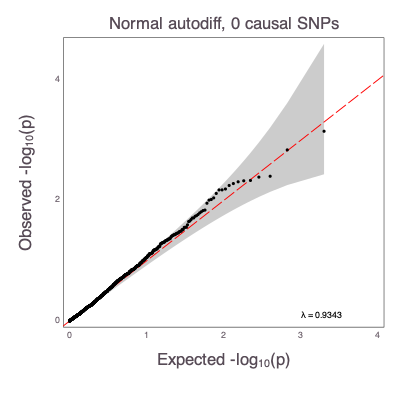

In [67]:
# check Gaussian using autodiff: it includes tau in grad/Hess -> not very different to excluding tau
qq(pvals, dpi=80, titles="Normal autodiff, $k causal SNPs")
display("image/png", read("qqplot.png"))

## Correctness: compare to autodiff

In [5]:
# autodiff
@time pvals = QuasiCopula.GWASCopulaVCModel_autodiff(qc_model, G)

R = 1.2944122036132124
Q = 334.07504773219074
W = [-4.1101463769673385, -0.38710090503513683, 10.128626121553435, 28.08718187630317, -3.9828060609992217]


LoadError: UndefVarError: fdsa not defined

In [9]:
# mathematical
@time pvals = QuasiCopula.GWASCopulaVCModel(qc_model, G)

R = 1.2944122028286387
Q = 334.07504773003683
W = [-4.110146378536879, -0.3871009113902798, 10.128626122634698, 28.087181876303358, -3.9828060609994456]


LoadError: UndefVarError: fdsa not defined